#Cognitive and Neural Dynamics Lab Tutorials
##Power Spectral Density (PSD)

#####Torben Noto 2015

You can look at any signal in the **time** domain or the **frequency** domain.

The power spectral density (PSD) is one way of visualizing what frequencies are present in a signal.

In this tutorial I'll give you an intuition for what a power spectrum is and tell you a common way of calculating it.

In [2]:
#setting settings and loading modules
from __future__ import division

%config InlineBackend.figure_format = 'retina'
%pylab inline

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

Populating the interactive namespace from numpy and matplotlib


In [4]:
#loading data
filename = 'emodat.mat'
filename = os.path.join('./', filename)

data = sp.io.loadmat(filename)
srate = data['srate']
data = data['data'] #ECoG data
data =  squeeze(data); #should be 1459920
print srate #should be 1017.25333333
print len(data) #should be 1476035 

[[ 1017.25333333]]
1476035


The sampling rate is important for how we analyze data in the frequency domain. When you digitally record a signal, you measure it at a certain rate. For this reason, we don't know the exact amplitude of any digital signal at every single point in time. Our best guess is the closest sample to a given point in time.

If we have a faster sampling rate, we can have better **temporal resolution** but storing excessive samples can make the **file size** too big and use too much **memory**.

In this case we gathered 1017.25333333 samples of data each second. If we want, we can resample the data using a different sampling rate.


Resampling, PSD, and many other things we do in this lab fall under the title of Digital Signal Processing. You can read more about it for free here: http://dspguide.com/


In the next cell we're going to resample our data to a different sampling rate. Someone might **downsample** their data to make the file smaller but we're going to resample beacuse it will help us to have an even number of samples in each second later on.

In [5]:
newsrate = 1024 # new sampling rate

data_resampled = sp.signal.resample(data, int(np.floor(len(data)*(newsrate/srate)))) 

#How many seconds of data do we have?
print str(len(data_resampled)) + ' total samples'
print str(len(data_resampled)/1024) + ' seconds of data' #Total samples of data sampled at 1024 / sampling rate = total seconds sampled


1485824 total samples
1451.0 seconds of data


#####So there's this complicated math function called the Fourier transform. 

This function measures the amplitude of every frequency in a signal. The math that it takes to do this is very challenging but we don't have to get too deep into it.

Imagine you play a chord on a piano. If you ran a Fourier transform on the sound signal, you could see how hard you pressed each of the keys.

In the brain, there are a lot of frequencies present in the same signal and they aren't as simple as a chord with 3 discrete notes.

In the next cells I'll make a complex signal and show you how to run a fourier transform on it.
 

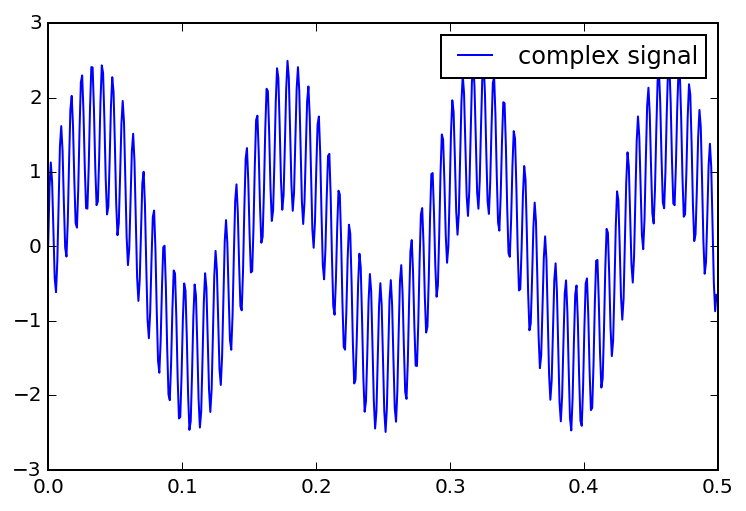

In [6]:
f = 1024 #sampling frequency
dur = 10 #10 seconds of signal
freq = 7 #7 Hz signal
freq2 = 130 #130 Hz signal
t = arange(0, dur, 1/f) #times for d
sig1 = sin(2 * pi * freq * t) #10 Hz wavelength
sig1 = 1.5*sig1; #increase the power of signal 1
sig2 = sin(2 *pi * freq2 * t) #130 Hz wavelength
plt.plot(t[0:512],sig1[0:512]+sig2[0:512], label = 'complex signal') #plot 0.5 seconds of data
legend()

To make the signal in the graph above, I added 2 sin waves together.
There is a slower wave with a large amplitude and a fast wave with a smaller amplitude. Make sure that you pick these out. We can use a fourier transform to prove that there are two signals that we can add together to produce this and show what frequencies these are.

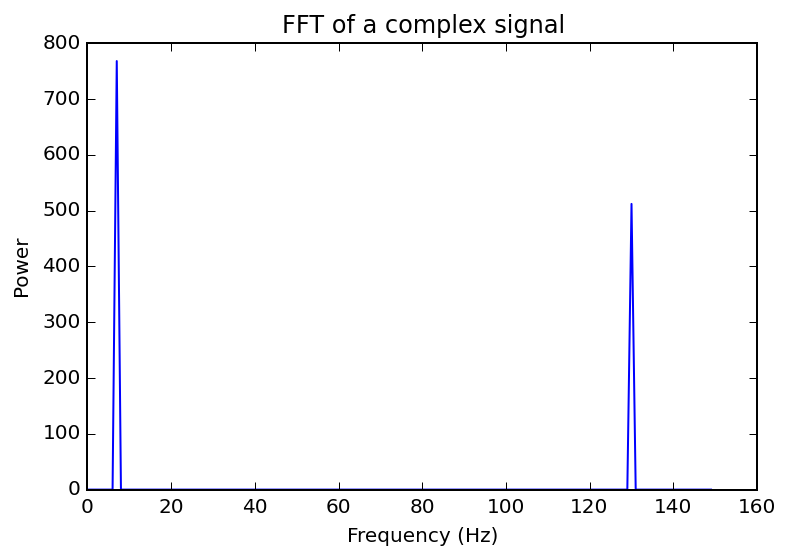

In [7]:
fourier = np.fft.fft(sig1+sig2,1024)
plot(abs(fourier[0:150]))
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of a complex signal')

So in this plot we're looking at the power of all of the freqencies present in our signal.

We can clearly see that there is a peak at 7 Hz and a peak at 130 Hz.
We can also see that the 7 Hz peak has a greater amplitude than the one at 130 Hz.

Pretty freakin cool.

However, notice that when we do this, we can't see any information about the timing in our signal. When looking at a signal in frequency space, we know nothing about the **offset of the phases** of these signals.

But we still have information about phase. This information is stored as complex numbers that we're not plotting above. It's called a fourier **transform** because **no information is lost when we apply it** You can calculate the fourier transform or the inverse fourier transform of a signal over and over again and not lose any information about it.
Way cool, but that's way too much math for today.

Now let's shift gears to something more interesting - What does a neural signal and its fft look like?

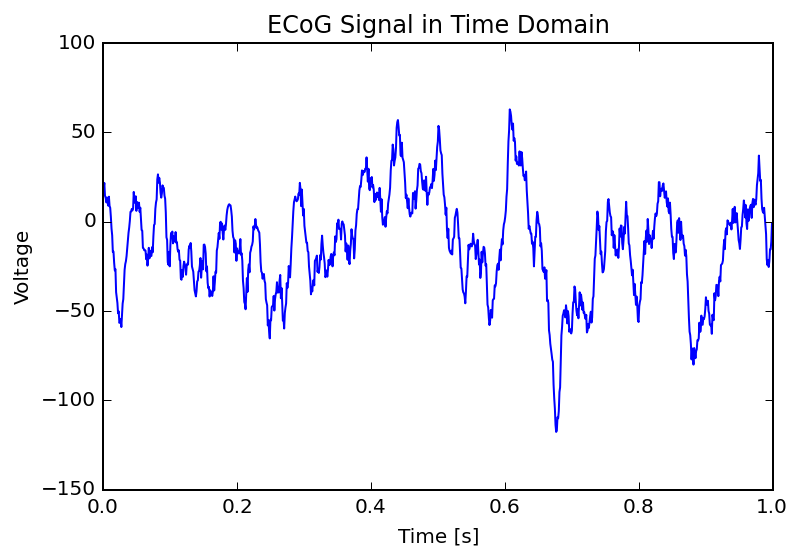

In [17]:
plot(np.arange(0, 1024)/1024., data[10000:11024])
plt.ylabel('Voltage')
plt.xlabel('Time [s]')
plt.title('ECoG Signal in Time Domain')

Above is 1 second of neural data. You might observe some up-and-downs and conclude that it is oscillatory, but it's not too insightful otherwise. Now let's take a look at its Fourier Transform.

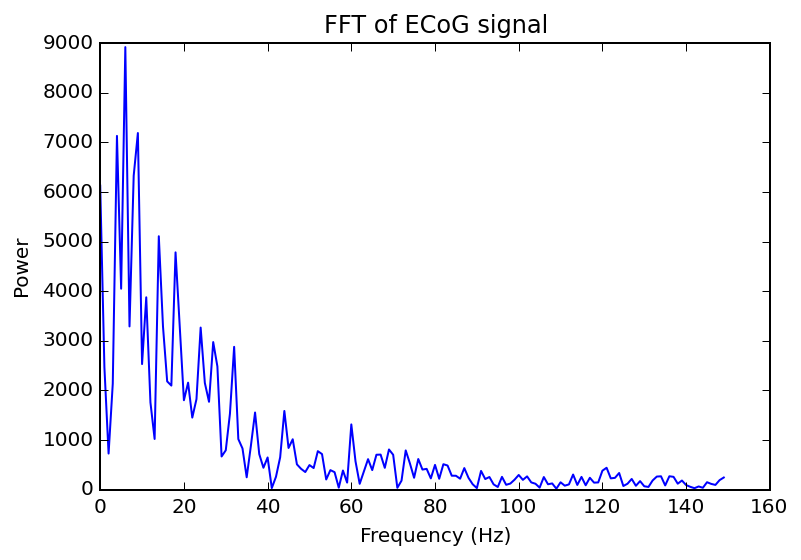

In [8]:
fourier = np.fft.fft(data,1024)
plot(abs(fourier[0:150])) #any frequencies above 150 Hz are probably noise

plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of ECoG signal')

#####Woah. So there's a lot going on. Let's break this down.

This signal is very noisy. There appear to be many wavelengths that contribute to this signal.
Longer wavelengths seem to have a larger power than shorter wavelengths.

#####Optional Side Note
Actually, the equation for this line is P = 1/f. This is a very special mathmatical ratio called a power law distribution or pink noise. 1/f relationships show up everywhere in nature in spooky ways. Sizes of earthquakes, stuff going on in the stock market, sizes of craters on the moon, and even the power spectrum of popular music all have power law distributions. Really interesting and spooky stuff.


#####Back to neuroscience
There's a way to smooth out our fft without losing too much information. The most common way of doing this is by using **Welch's method**.
Basically, we calculate the fft of a signal across a few sliding windows. Then we calculate the mean PSD from all the sliding windows.

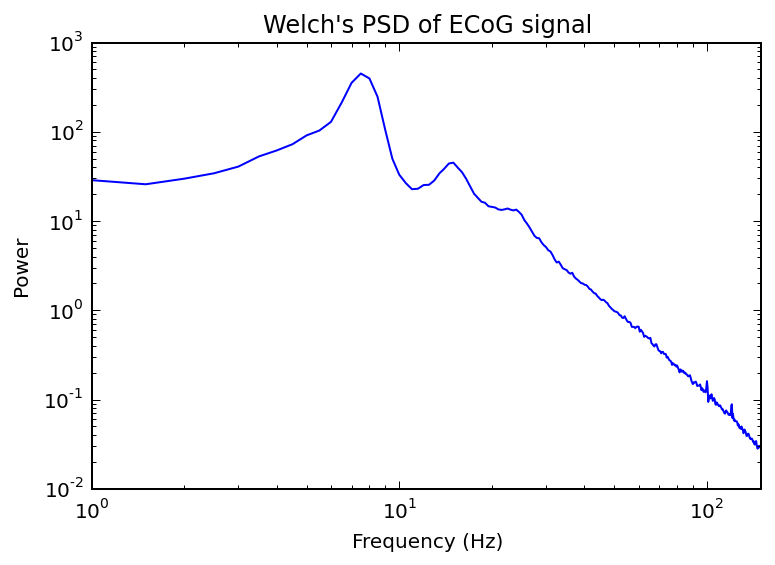

In [27]:
f,pspec = sp.signal.welch(data, fs=newsrate, window='hanning', nperseg=2*newsrate, noverlap=newsrate/2, nfft=None, detrend='linear', return_onesided=True, scaling='density')
#Try to figure out what the paramaters above are doing. What happens if you change them?

loglog(f[0:150*2],pspec[0:150*2])
#Any frequencies with >150 Hz are going to be noise in ECoG data.
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.xlim([1, 150])
plt.title("Welch's PSD of ECoG signal")

#####Look at that!

Now the signal is much cleaner and there seem to be some interesting peaks around 8, 14, and 25 Hz. These are known as the theta, alpha, and beta bands.
These wavelengths have been studied since the 1950's but we really don't know much about them.
http://en.wikipedia.org/wiki/Electroencephalography

**Note** that this plot of the PSD is in **log-log**, meaning that both the x- and y-axis are scaled in log10 units, where the space between 1 to 10 is the same as between 10 to 100.

One major goal of the Cogntive and Neural Dynamics Lab is to understand the physiological mechanism behind these wavelengths and the shape of the brain's PSD.

Why does the PSD of neural data have a 1/f distribution and why are there peaks?
What factors are correlated with the shapes of the peaks: brain region, age, mental illnesses, cognitive task?
What are the physiological bases of these peaks. 
Can we build neural network models that look like this?